In [1]:
import matplotlib.pyplot as plt
import os
import tables_io
import tempfile
from rail.core.stage import RailStage
from rail.core.data import TableHandle
from rail.core.utils import RAILDIR
from rail.core.utilStages import LSSTFluxToMagConverter, Dereddener

In [2]:
DS = RailStage.data_store
example_file = os.path.join(RAILDIR, "rail", "examples_data", "testdata", "rubin_dm_dc2_example.pq")
test_data = DS.read_file("test_data", TableHandle, example_file)

In [3]:
test_data().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   objectId          100 non-null    int64  
 1   ra                100 non-null    float64
 2   decl              100 non-null    float64
 3   u_gaap1p0Flux     100 non-null    float64
 4   u_gaap1p0FluxErr  100 non-null    float64
 5   g_gaap1p0Flux     100 non-null    float64
 6   g_gaap1p0FluxErr  100 non-null    float64
 7   r_gaap1p0Flux     100 non-null    float64
 8   r_gaap1p0FluxErr  100 non-null    float64
 9   i_gaap1p0Flux     100 non-null    float64
 10  i_gaap1p0FluxErr  100 non-null    float64
 11  z_gaap1p0Flux     100 non-null    float64
 12  z_gaap1p0FluxErr  100 non-null    float64
 13  y_gaap1p0Flux     100 non-null    float64
 14  y_gaap1p0FluxErr  100 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 11.8 KB


To convert mags to fluxes, we need to specify patterns for the `flux_name` and `flux_err_name` columns to be converted, and the `mag_name` and `mag_err_name` columsn that will store the newly created magnitudes.  This is done as below, by specifying a string listing the bands, and `{band}` in the patterns where the individual bands will go.  The dictionary below duplicates the default behavior of the converter, but is written out explicitly as an example:

In [4]:
# convert "gaap" fluxes to magnitudes:
ftomagdict = dict(bands = "ugrizy",
                  flux_name="{band}_gaap1p0Flux",
                  flux_err_name="{band}_gaap1p0FluxErr",
                  mag_name="mag_{band}_lsst",
                  mag_err_name="mag_err_{band}_lsst",
                  copy_cols=["ra", "decl", "objectId"])
fluxToMag = LSSTFluxToMagConverter.make_stage(name='flux2mag', **ftomagdict)

In [5]:
mags_data = fluxToMag(test_data)

Inserting handle into data store.  output_flux2mag: inprogress_output_flux2mag.hdf5, flux2mag


/Users/sam/TMP/fluxmag/RAIL/src/rail/core/utilStages.py:141: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(flux_vals) + self.config.mag_offset


In [6]:
list(mags_data().keys())

['mag_u_lsst',
 'mag_err_u_lsst',
 'mag_g_lsst',
 'mag_err_g_lsst',
 'mag_r_lsst',
 'mag_err_r_lsst',
 'mag_i_lsst',
 'mag_err_i_lsst',
 'mag_z_lsst',
 'mag_err_z_lsst',
 'mag_y_lsst',
 'mag_err_y_lsst',
 'ra',
 'decl',
 'objectId']

To deredden magnitudes we need to grab one of the dust maps used by the `dustmaps` package.  We'll grab the default Schlegel-Finkbeiner-Davis "SFD" map.  NOTE: This will download a file to your machine containing the SFD data!

In [7]:
from dustmaps.config import config
config['data_dir'] = "./"
import dustmaps.sfd
dustmaps.sfd.fetch()

 64.0 MiB of 64.0 MiB |  26.2 MiB/s |###################| 100% | ETA:  00:00:00

 61.4 MiB of 64.0 MiB |  25.7 MiB/s |################## |  95% | ETA:   0:00:00

We need to feed the location of the directory containing the newly created "sfd" maps to the stage, as we downloaded the data to the present working directory with the command above, that directory is just `"./"`

In [8]:
dustmap_dir = "./"

dereddener = Dereddener.make_stage(name='dereddener', dustmap_dir=dustmap_dir)
deredden_data = dereddener(mags_data)

Inserting handle into data store.  output_dereddener: inprogress_output_dereddener.hdf5, dereddener


In [9]:
deredden_data().keys()

dict_keys(['mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst'])

We see that the deredden stage returns us a dictionary with the dereddened magnitudes. Let's plot the difference of the un-dereddened magnitudes and the dereddened ones for u-band to see if they are, indeed, slightly brighter:

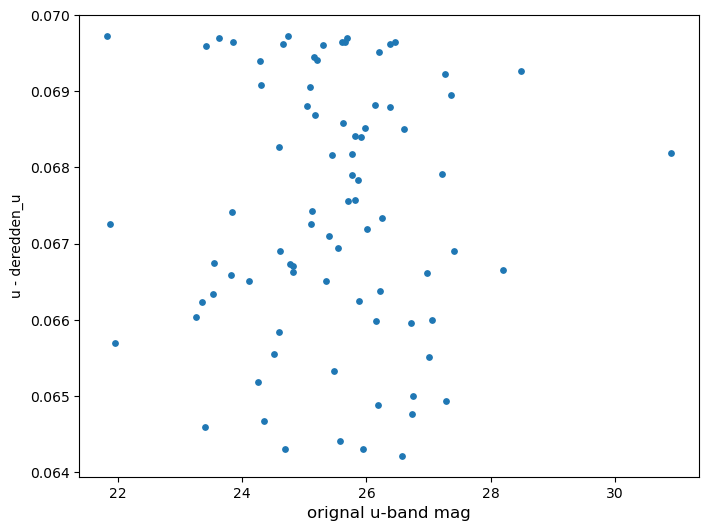

In [10]:
delta_u_mag = mags_data()['mag_u_lsst'] - deredden_data()['mag_u_lsst']
plt.figure(figsize=(8,6))
plt.scatter(mags_data()['mag_u_lsst'], delta_u_mag, s=15)
plt.xlabel("orignal u-band mag", fontsize=12)
plt.ylabel("u - deredden_u");

In [11]:
# for cleanup, let's delete the SFD map files that we downloaded, uncomment the line below to delete that map directory
#! rm -rf sfd/